In [1]:
# The goal of this nb is to create a ML model to predict the expected loss (for the insurance company) given an individual and their subsequent characteristics such as age, sex, smoking, etc. 

# ExpAmt fields – these values represent the expected claim amounts for the policy year based upon certain mortality tables (such as the 2015 vbt, for example).
    # The values depend upon various factors such as issue age, sex, smoker/non-smoker, and duration.
    # For example, suppose we had a policy issued on a 20-year-old male non-smoker that is now in its 10th policy year (duration = 10, and the insured is now 30 years old).
    # According to the 2015 vbt table, the expected death rate for such a person is 0.44 per 1000; said differently, you could say that such an individual has a 0.44/1000 = 0.00044 probability of dying that year.
    # If the policy were for 500,000, then our expected claim amount for the policy year would be 500,000 * 0.44 / 1000 = 220.
    # As you might expect, older individuals will typically have a higher probability of dying and thus higher expected claim amounts for the same policy size.
    # Similarly, different smoker status and/or sex will affect the expected claim amounts.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import math
import seaborn as sns

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [3]:
# Bring in Data and Select Input and Output variable(s)


# Path for PC --- Uncomment out depending on device
# df0 = pd.read_csv(r'C:\Users\oakle\OneDrive\Documents\Code\Mortality\Mortality\Mort2020.csv')
# df1 = pd.read_csv(r'C:\Users\oakle\OneDrive\Documents\Code\Mortality\Mortality\Mort2021.csv')
# df2 = pd.read_csv(r'C:\Users\oakle\OneDrive\Documents\Code\Mortality\Mortality\Mort2022.csv')
# df3 = pd.read_csv(r'C:\Users\oakle\OneDrive\Documents\Code\Mortality\Mortality\Mort2023.csv')


# Path for Laptop
df0 = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2020.csv')
df1 = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2021.csv')
df2 = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2022.csv')
df3 = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2023.csv')


df = pd.concat([df0,df1,df2,df3], axis=0,ignore_index=True,)

df = df.drop_duplicates()

C:\Users\oakle\AppData\Local\Temp\ipykernel_30476\566321185.py:12: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df0 = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2020.csv')
C:\Users\oakle\AppData\Local\Temp\ipykernel_30476\566321185.py:13: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2021.csv')
C:\Users\oakle\AppData\Local\Temp\ipykernel_30476\566321185.py:14: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2022.csv')
C:\Users\oakle\AppData\Local\Temp\ipykernel_30476\566321185.py:15: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv(r'C:\Users\oakle\Documents\Sch

In [4]:
# Define X variable
X = df[['CvgSexCode',
        'CvgIssueAge',
        'Duration',
        'AttainedAge',
        'PivotTobaccoCode',
        'UWClass',
        'MortExposureAmt',
        'TableRating'
        ]]

# Print X
X

,CvgSexCode,CvgIssueAge,Duration,AttainedAge,PivotTobaccoCode,UWClass,MortExposureAmt,TableRating
0,M,33,20,52,S,ST,100000.000000,NaN
1,F,53,20,72,N,SN,5416.666667,NaN
2,F,52,20,71,N,SN,14166.666670,NaN
3,M,28,20,47,S,ST,16500.000000,NaN
4,M,52,20,71,S,ST,8041.666667,NaN
...,...,...,...,...,...,...,...,...
3324015,M,45,15,59,N,SN,100000.000000,B
3324016,M,26,19,44,N,SN,100000.000000,NaN
3324017,M,26,18,43,N,PN,250000.000000,NaN
3324018,M,36,16,51,S,PT,350000.000000,NaN


In [5]:
X.reset_index(inplace=True,drop=True)

# Define how UWClass will map to numerical values
map = {'SN': 1,
       'PN': 2,
       'SS': 3,
       'SP': 4,
       'ST': 5,
       'PP': 6,
       'PT': 7,
       'PS': 8
        }

# Convert sex code to binary
X['IsMale'] = np.where(X['CvgSexCode'] == 'M', 1, 0)

# Convert smoker status to binary
X['IsSmoker'] = np.where(X['PivotTobaccoCode'] == 'S', 1, 0)

# Convert substandard to binary
X['IsSubStandard'] = np.where(X['TableRating'].isna(), 0, 1)

# Convert UnderWritingClass to numeric classes
X['UWClass'] = X['UWClass'].replace(map)

# Remove old columns that have been converted to binary values
X = X.drop(columns=['TableRating','PivotTobaccoCode','CvgSexCode','UWClass'])

# Print X
X

C:\Users\oakle\AppData\Local\Temp\ipykernel_30476\883233028.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['IsMale'] = np.where(X['CvgSexCode'] == 'M', 1, 0)
C:\Users\oakle\AppData\Local\Temp\ipykernel_30476\883233028.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['IsSmoker'] = np.where(X['PivotTobaccoCode'] == 'S', 1, 0)
C:\Users\oakle\AppData\Local\Temp\ipykernel_30476\883233028.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. T

In [7]:
# Print Amount of outliers (SubStandard Individuals)
print(X['IsSubStandard'].value_counts())

IsSubStandard
0    3051111
1     272909
Name: count, dtype: int64


In [8]:
# Define output variables
y = df[['2015vbtExpAmt','2015vbtCompositeExpAmt']]
y

,2015vbtExpAmt,2015vbtCompositeExpAmt
0,483.000000,266.000000
1,53.895833,82.062500
2,125.091667,193.375000
3,54.450000,29.370000
4,255.403333,139.844583
...,...,...
3324015,340.000000,499.000000
3324016,111.000000,155.000000
3324017,265.000000,367.500000
3324018,1456.000000,801.500000


             delta_y
0       -19040.74602
1       -16160.00000
2       -15805.38656
3       -15604.11648
4       -14860.00000
...              ...
3324015  16150.00000
3324016  16170.00000
3324017  16589.29920
3324018  17850.00000
3324019  17900.00000

[3324020 rows x 1 columns]


<function matplotlib.pyplot.show(close=None, block=None)>

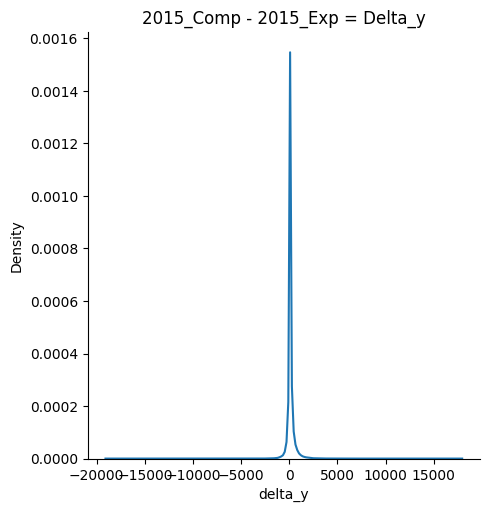

In [16]:
# Plot the distribution of 2015exp vs 2015compExp to get a qualitative idea of how they differ
delta_y = np.array(y['2015vbtCompositeExpAmt'] - y['2015vbtExpAmt'])
delta_y.sort()
delta_y = pd.DataFrame({'delta_y': delta_y})

print(delta_y)

sns.displot(kind='kde',
            data = delta_y,
            x='delta_y'
            )
plt.title('2015_Comp - 2015_Exp = Delta_y')
plt.show

In [17]:
# Designate 80% of Data for training the model and 20% for Testing/Validation
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.8,test_size=.2,random_state=50)

# ------------------- FROM THIS POINT ON ALL TRAIN AND TEST DATA MUST BE SEPARATE. --------------------------------

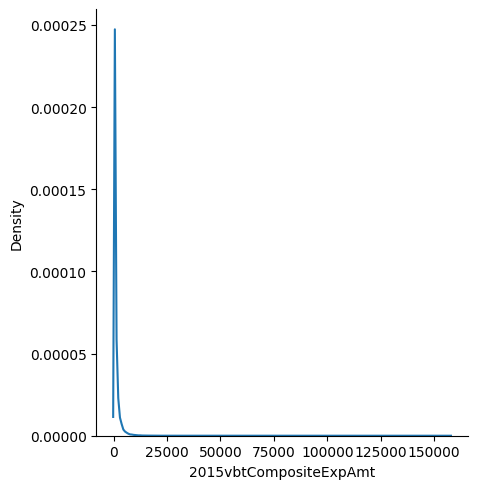

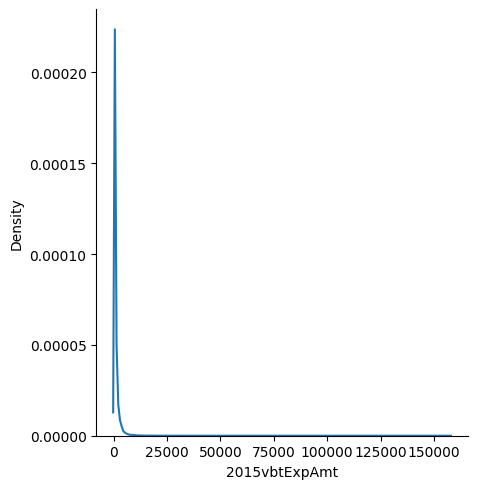

In [18]:
# Plot distributions

# Info on the type of distribution graph:
# https://seaborn.pydata.org/generated/seaborn.displot.html

sns.displot(kind='kde',
           data=y_train,
           x='2015vbtCompositeExpAmt'
           )


sns.displot(kind='kde',
           data=y_train,
           x= '2015vbtExpAmt'
           )


plt.show()

#

In [1]:
#---------------------------------------------- Create Multicollinearity Matrix for 2015_Norm Variable ---------------------------------

# If num > .90 , Column x Row are collinear
X_train = pd.DataFrame(X_train)

# Put Y infront of X variables
Xy_collin = pd.concat([y_train['2015vbtExpAmt'] , X_train.drop(columns=['IsMale','IsSmoker','IsSubStandard'],axis =1)],axis = 1)

# Define collin as standard scaler - [See Sklearn docs for more info]
collin = StandardScaler()

# Fit collin
collin_fit = collin.fit(Xy_collin)

# Convert collin fit back to pd.Dataframe
df_collin = pd.DataFrame(collin_fit.transform(Xy_collin))
df_collin.columns = Xy_collin.columns
df_collin.index = Xy_collin.index

corr_m = df_collin.corr(method='pearson')

corr_m_abs = corr_m.abs()
corr_m_upper = corr_m_abs.where(
    np.triu(np.ones(corr_m_abs.shape), k=1).astype(bool))

corr_m_upper

# Notes:
# Take a look at using Variance inflation factor or CP and CP Plot

NameError: name 'pd' is not defined

In [13]:
#---------------------------------------------- Create Multicollinearity Matrix for 2015_Composite Variable ---------------------------------


# If num > .90 , Column x Row are collinear
X_train = pd.DataFrame(X_train)
# Put Y infront of X variables
Xy_collin = pd.concat([y_train['2015vbtCompositeExpAmt'] , X_train.drop(columns=['IsMale','IsSmoker','IsSubStandard'])], axis =1)

# Define collin as standard scaler - [See Sklearn docs for more info]
collin = StandardScaler()

# Fit collin
collin_fit = collin.fit(Xy_collin)

# Convert collin fit back to pd.Dataframe
df_collin = pd.DataFrame(collin_fit.transform(Xy_collin))
df_collin.columns = Xy_collin.columns
df_collin.index = Xy_collin.index

corr_m = df_collin.corr(method='pearson')

corr_m_abs = corr_m.abs()
corr_m_upper = corr_m_abs.where(
    np.triu(np.ones(corr_m_abs.shape), k=1).astype(bool))

corr_m_upper

,2015vbtCompositeExpAmt,CvgIssueAge,Duration,AttainedAge,MortExposureAmt
2015vbtCompositeExpAmt,NaN,0.250597,0.118642,0.314765,0.301935
CvgIssueAge,NaN,NaN,0.268737,0.726964,0.011517
Duration,NaN,NaN,NaN,0.466053,0.179698
AttainedAge,NaN,NaN,NaN,NaN,0.117528
MortExposureAmt,NaN,NaN,NaN,NaN,NaN


<function matplotlib.pyplot.show(close=None, block=None)>

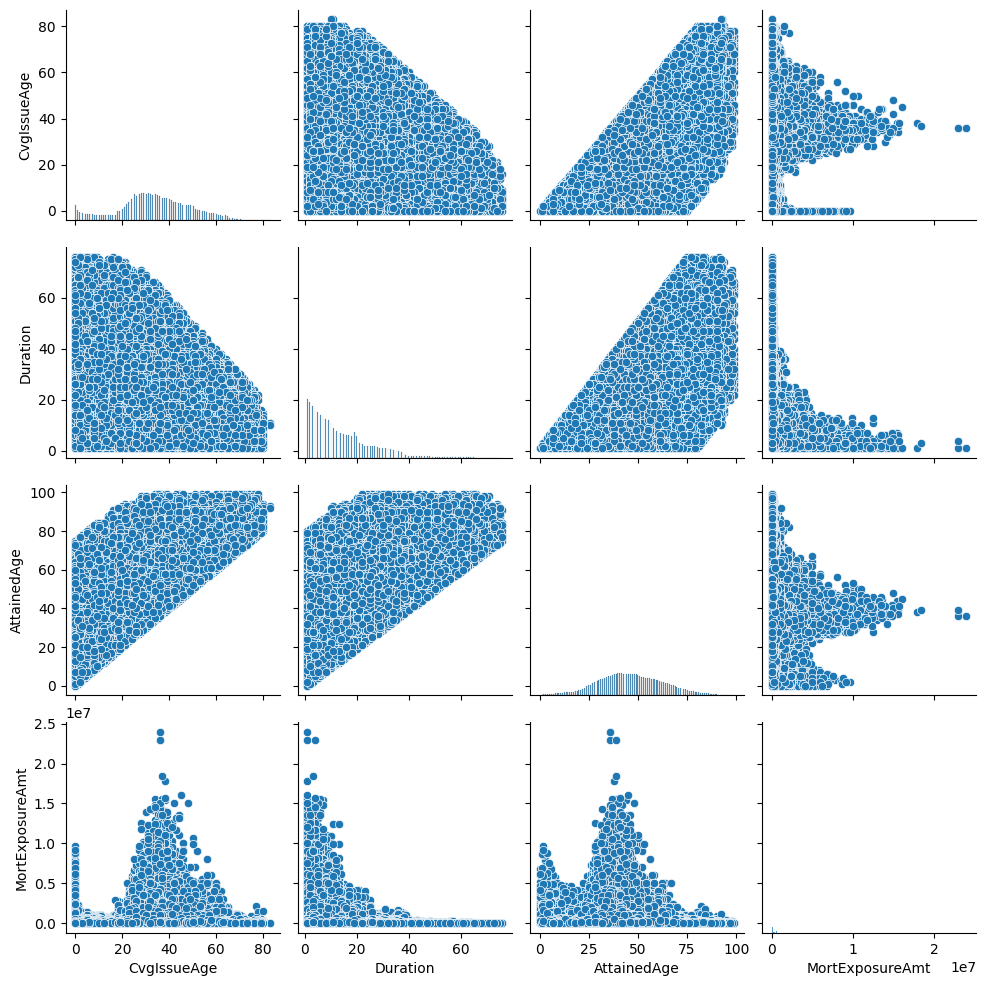

In [14]:
# Create Pairplot to check for weird Data (Purely Qualitative)
# Simply checking for any abnomalities and outliers

sns.pairplot(data=(X_test.drop(columns=['IsMale','IsSmoker','IsSubStandard'])))
plt.show

In [66]:
# Define the Plot and regress method
def plot_and_measure_regression(model_name :str , y_pred, y_true, variable:str):

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    y_pred_sorted = np.sort(y_pred, axis=0)
    y_true_sorted = np.sort(y_true, axis=0)

    plt.figure
    plt.plot(y_pred_sorted, color = 'Blue', label = 'Predicted')
    plt.plot(y_true_sorted, color = 'Orange', label = 'Expected')
    plt.title(f'{model_name} Regression Chart - {variable}')
    plt.xlabel('Sorted Index (meaningless)')
    plt.xlim(660000,(len(y_pred) + 250))
    plt.legend()
    plt.ylabel(f'Payout amount ($\'s) - {variable}')
    plt.show()


# Define Expected vs Predicted graph function
def exp_vs_pred(model_name :str, y_pred, y_true,variable:str):

    plt.scatter(x= y_true, y= y_pred, color = 'Blue')
    plt.axline(xy1=(0,0), slope= 1, color = 'Orange',label = 'Ideal Line')
    plt.title(f'{model_name} Expected vs Predicted - {variable}')
    plt.legend()
    plt.xlabel(f'{variable}_true')
    plt.ylabel(f'{variable}_pred')
    plt.show()


# Define function to print MSE and R2 values
def print_scores(y_pred, y_true, model:str, variable:str):
    
    MSE = mean_squared_error(y_true= y_true,
                              y_pred=y_pred
                              )
    R2 = r2_score(y_true= y_true,
                   y_pred=y_pred)
    
    print(f'{model} R2 Score = {R2}')
    print(f'{model} MSE Score = {MSE}')


# Define function to return MSE and R2 values
def get_scores(y_pred, y_true):
    
    MSE = mean_squared_error(y_true= y_true,
                              y_pred=y_pred
                              )
    
    R2 = r2_score(y_true= y_true,
                   y_pred=y_pred)
    
    return {'R2':R2,
            'MSE': MSE
            }

Gradient Boosting R2 Score = 0.9152025447589942
Gradient Boosting MSE Score = 86107.70287024534


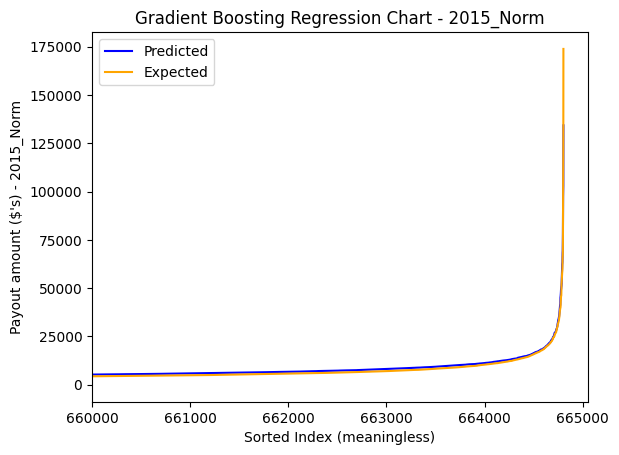

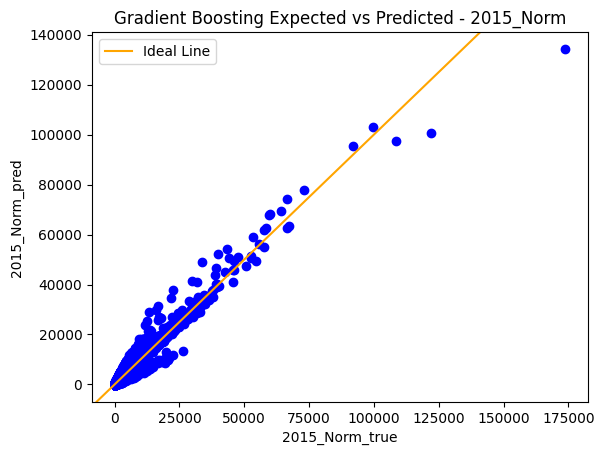

In [67]:
# ----------------------  Test 1.a - Histogram Gradient Boosted Trees for 2015 Expected Amt ------------------------------------

# Shortcut to minimize typing - Uncomment depending on 2015 Normal or Comp

test_data = y_test['2015vbtExpAmt']
# test_data = y_test['2015vbtCompositeExpAmt']

variable_name = '2015_Norm'
# variable_name = '2015_Composite'

train_data = y_train['2015vbtExpAmt']
# train_data = y_train['2015vbtCompositeExpAmt']

model_name = 'Gradient Boosting'



# Define model and train using Train data only
HBGT_model = HistGradientBoostingRegressor(loss ='squared_error')

# Convert y_train to dataframe for compatability
y_train = pd.DataFrame(y_train)

# Train model
HBGT_model.fit(X_train,y_train['2015vbtCompositeExpAmt'])

# Use trained model to predict Y for validation
y_pred = HBGT_model.predict(X_test)



# Evaluate Model using R^2, MSE, and graphs
print_scores(y_pred= y_pred,
             y_true= test_data,
             model= model_name,
             variable= variable_name,
             )

plot_and_measure_regression(model_name= model_name,
                            y_pred= y_pred,
                            y_true= test_data,
                            variable= variable_name
                               )

exp_vs_pred(model_name= model_name,
            y_pred= y_pred,
            y_true= test_data,
            variable= variable_name
            )

HGBR_a_scores = get_scores(y_pred= y_pred,
                           y_true= test_data,
                           )

Gradient Boosting R2 Score = 0.9152025447589942
Gradient Boosting MSE Score = 86107.70287024534


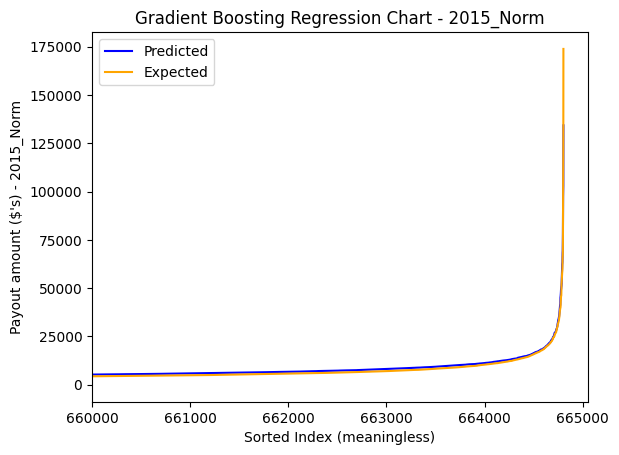

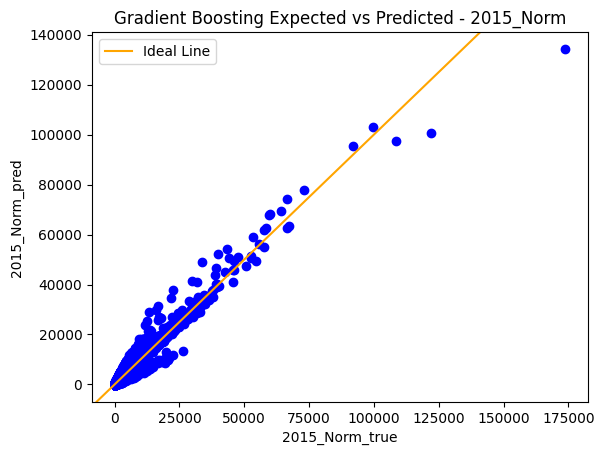

In [ ]:
# ----------------------  Test 1.a - Histogram Gradient Boosted Trees for 2015 Expected Amt ------------------------------------

# Shortcut to minimize typing - Uncomment depending on 2015 Normal or Comp

test_data = y_test['2015vbtExpAmt']
# test_data = y_test['2015vbtCompositeExpAmt']

variable_name = '2015_Norm'
# variable_name = '2015_Composite'

train_data = y_train['2015vbtExpAmt']
# train_data = y_train['2015vbtCompositeExpAmt']

model_name = 'Gradient Boosting'



# Define model and train using Train data only
HBGT_model = HistGradientBoostingRegressor(loss ='squared_error')

# Convert y_train to dataframe for compatability
y_train = pd.DataFrame(y_train)

# Train model
HBGT_model.fit(X_train,y_train['2015vbtCompositeExpAmt'])

# Use trained model to predict Y for validation
y_pred = HBGT_model.predict(X_test)



# Evaluate Model using R^2, MSE, and graphs
print_scores(y_pred= y_pred,
             y_true= test_data,
             model= model_name,
             variable= variable_name,
             )

plot_and_measure_regression(model_name= model_name,
                            y_pred= y_pred,
                            y_true= test_data,
                            variable= variable_name
                               )

exp_vs_pred(model_name= model_name,
            y_pred= y_pred,
            y_true= test_data,
            variable= variable_name
            )

HGBR_a_scores = get_scores(y_pred= y_pred,
                           y_true= test_data,
                           )

Gradient Boosting R2 Score = 0.9867317994120831
Gradient Boosting MSE Score = 16478.5437362108


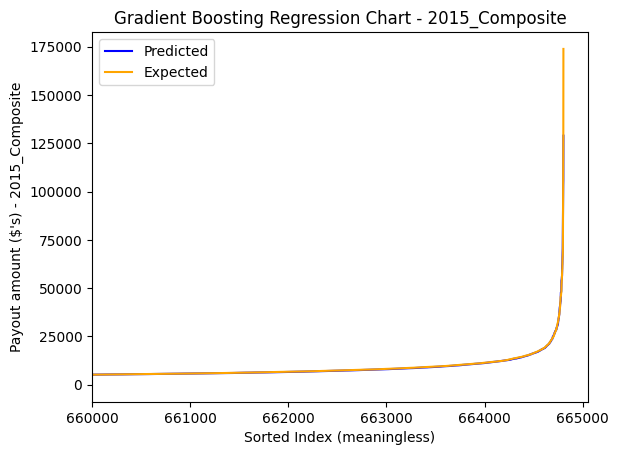

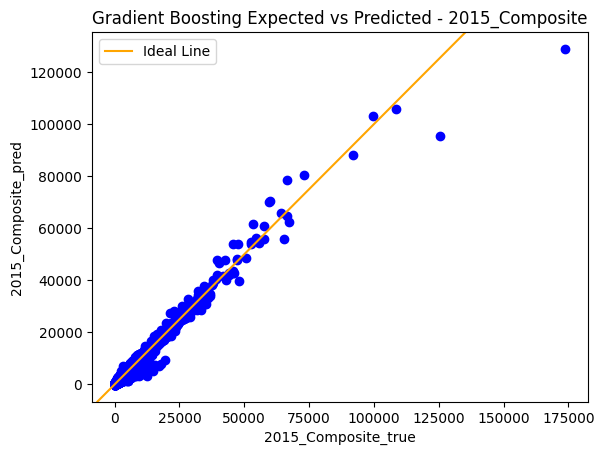

In [68]:
# ----------------------  Test 1.b - Histogram Gradient Boosted Trees for 2015 Composite Expected Amt------------------------------------

# Shortcut to minimize typing - Uncomment depending on 2015 Normal or Comp

# test_data = y_test['2015vbtExpAmt']
test_data = y_test['2015vbtCompositeExpAmt']

# variable_name = '2015_Norm'
variable_name = '2015_Composite'

# train_data = y_train['2015vbtExpAmt']
train_data = y_train['2015vbtCompositeExpAmt']

model_name = 'Gradient Boosting'



# Define model and train using Train data only
HBGT_model = HistGradientBoostingRegressor(loss ='squared_error')

# Convert y_train to dataframe for compatability
y_train = pd.DataFrame(y_train)

# Train model
HBGT_model.fit(X_train,y_train['2015vbtCompositeExpAmt'])

# Use trained model to predict Y for validation
y_pred = HBGT_model.predict(X_test)



# Evaluate Model using R^2, MSE, and graphs
print_scores(y_pred= y_pred,
             y_true= test_data,
             model= model_name,
             variable= variable_name,
             )

plot_and_measure_regression(model_name= model_name,
                            y_pred= y_pred,
                            y_true= test_data,
                            variable= variable_name
                               )

exp_vs_pred(model_name= model_name,
            y_pred= y_pred,
            y_true= test_data,
            variable= variable_name
            )

HGBR_b_scores = get_scores(y_pred= y_pred,
                           y_true= test_data,
                           )

Neural Network R2 Score = 0.16345224696729
Neural Network MSE Score = 849473.6681682706


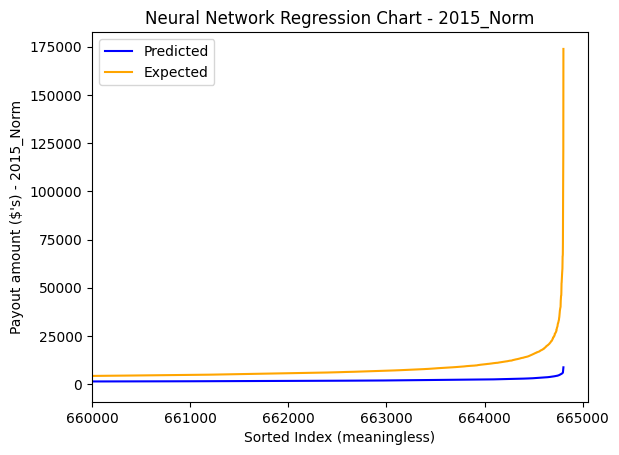

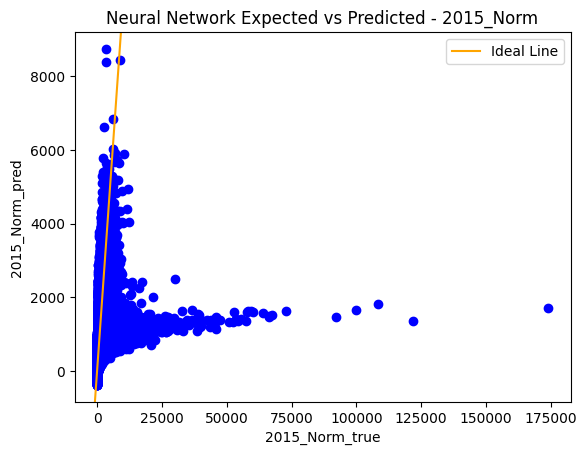

In [69]:
# -----------------------  Test 2.a - MLP Regressor (Neural Network) - 2015vbtExpAmt -----------------------------

# Shortcut to minimize typing - Uncomment depending on 2015 Normal or Comp

test_data = y_test['2015vbtExpAmt']
# test_data = y_test['2015vbtCompositeExpAmt']

variable_name = '2015_Norm'
# variable_name = '2015_Composite'

train_data = y_train['2015vbtExpAmt']
# train_data = y_train['2015vbtCompositeExpAmt']

model_name = 'Neural Network'




# Define the model using adam optimizer
NN_model = MLPRegressor(solver='adam',early_stopping=True,batch_size=1000)

# Train the model
NN_model.fit(X_train,y_train['2015vbtExpAmt'])

# use trained model and test data to predict output for validation
y_pred = NN_model.predict(X_test)


# Evaluate Model using R^2, MSE, and graphs
print_scores(y_pred= y_pred,
             y_true= test_data,
             model= model_name,
             variable= variable_name,
             )

plot_and_measure_regression(model_name= model_name,
                            y_pred= y_pred,
                            y_true= test_data,
                            variable= variable_name
                               )

exp_vs_pred(model_name= model_name,
            y_pred= y_pred,
            y_true= test_data,
            variable= variable_name
            )

NN_a_scores = get_scores(y_pred= y_pred,
                           y_true= test_data,
                           )

Neural Network R2 Score = 0.2578354205083354
Neural Network MSE Score = 921737.0058271035


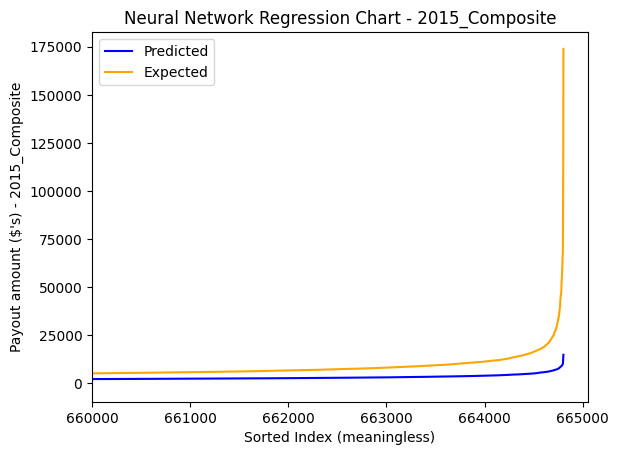

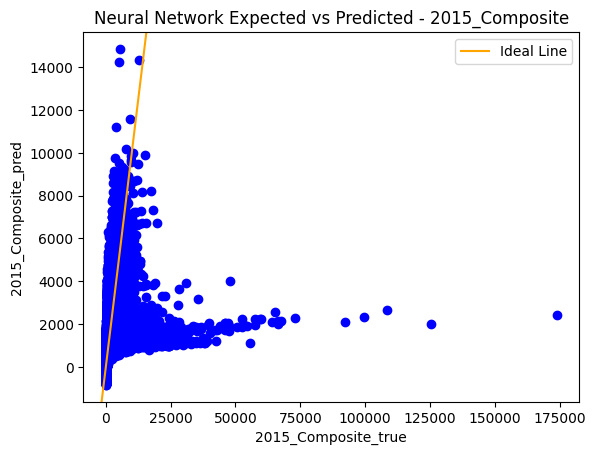

In [70]:
# -----------------------  Test 2.b - MLP Regressor (Neural Network) - 2015vbtCompositeExpAmt -----------------------------


# Shortcut to minimize typing - Uncomment depending on 2015 Normal or Comp

# test_data = y_test['2015vbtExpAmt']
test_data = y_test['2015vbtCompositeExpAmt']

# variable_name = '2015_Norm'
variable_name = '2015_Composite'

# train_data = y_train['2015vbtExpAmt']
train_data = y_train['2015vbtCompositeExpAmt']

model_name = 'Neural Network'



# Define the model using adam optimizer
NN_model = MLPRegressor(solver='adam',early_stopping=True,batch_size=1000)

# Train the model
NN_model.fit(X_train,train_data)

# use trained model and test data to predict output for validation
y_pred = NN_model.predict(X_test)


# Evaluate Model using R^2, MSE, and graphs
print_scores(y_pred= y_pred,
             y_true= test_data,
             model= model_name,
             variable= variable_name,
             )

plot_and_measure_regression(model_name= model_name,
                            y_pred= y_pred,
                            y_true= test_data,
                            variable= variable_name
                               )

exp_vs_pred(model_name= model_name,
            y_pred= y_pred,
            y_true= test_data,
            variable= variable_name
            )

NN_b_scores = get_scores(y_pred= y_pred,
                           y_true= test_data,
                           )

Random Forest R2 Score = 0.9933917526657108
Random Forest MSE Score = 6710.354648460006


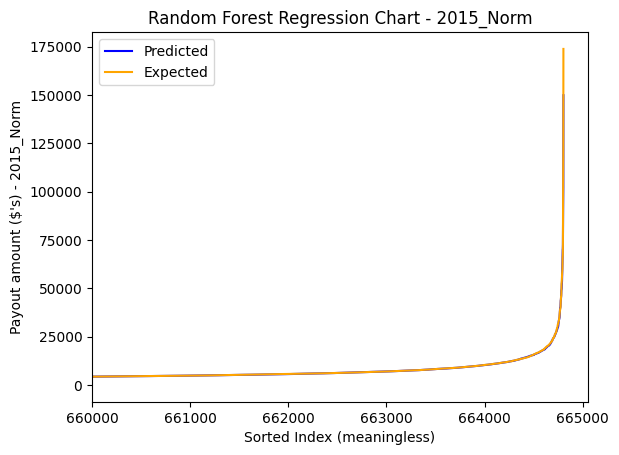

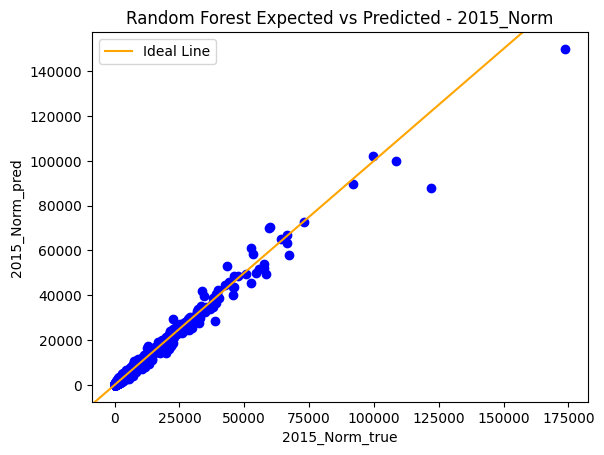

In [71]:
# ----------------------------------  Test 3.a - Random Forest Regression - 2015vbtExpAmt  -------------------------------------

# Shortcut to minimize typing - Uncomment depending on 2015 Normal or Comp

test_data = y_test['2015vbtExpAmt']
# test_data = y_test['2015vbtCompositeExpAmt']

variable_name = '2015_Norm'
# variable_name = '2015_Composite'

train_data = y_train['2015vbtExpAmt']
# train_data = y_train['2015vbtCompositeExpAmt']

model_name = 'Random Forest'



# Define Random Forest Model
RFR_model = RandomForestRegressor()

# Train model on train data
RFR_model.fit(X_train,train_data)

# Use trained model to predict test data
y_pred = RFR_model.predict(X_test)


# Evaluate Model using R^2, MSE, and graphs
print_scores(y_pred= y_pred,
             y_true= test_data,
             model= model_name,
             variable= variable_name,
             )

plot_and_measure_regression(model_name= model_name,
                            y_pred= y_pred,
                            y_true= test_data,
                            variable= variable_name
                               )

exp_vs_pred(model_name= model_name,
            y_pred= y_pred,
            y_true= test_data,
            variable= variable_name
            )

RFR_a_scores = get_scores(y_pred= y_pred,
                           y_true= test_data,
                           )

Random Forest R2 Score = 0.9954186277007047
Random Forest MSE Score = 5689.870552194894


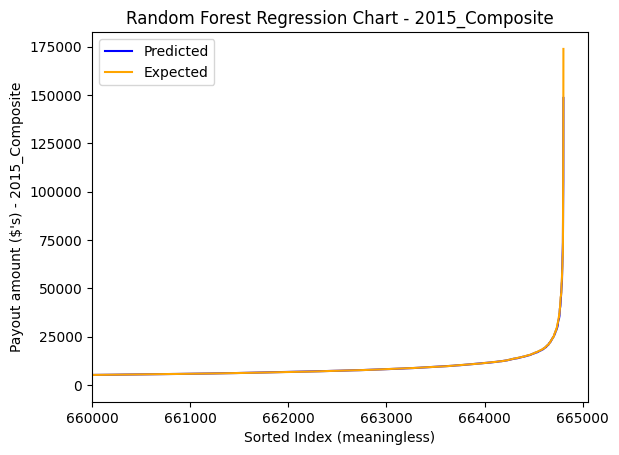

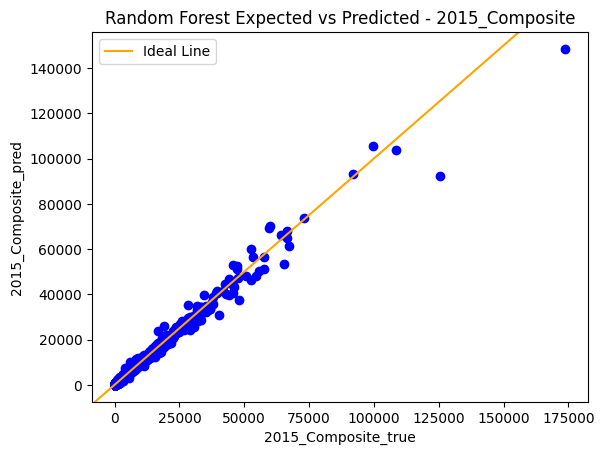

In [72]:
# ----------------------------------  Test 3.b - Random Forest Regression - 2015vbtCompositeExpAmt  -------------------------------------

# Shortcut to minimize typing - Uncomment depending on 2015 Normal or Comp

# test_data = y_test['2015vbtExpAmt']
test_data = y_test['2015vbtCompositeExpAmt']

# variable_name = '2015_Norm'
variable_name = '2015_Composite'

# train_data = y_train['2015vbtExpAmt']
train_data = y_train['2015vbtCompositeExpAmt']

model_name = 'Random Forest'



# Define Random Forest Model
RFR_model = RandomForestRegressor()

# Train model on train data
RFR_model.fit(X_train,train_data)

# Use trained model to predict test data
y_pred = RFR_model.predict(X_test)


# Evaluate Model using R^2, MSE, and graphs
print_scores(y_pred= y_pred,
             y_true= test_data,
             model= model_name,
             variable= variable_name,
             )

plot_and_measure_regression(model_name= model_name,
                            y_pred= y_pred,
                            y_true= test_data,
                            variable= variable_name
                               )

exp_vs_pred(model_name= model_name,
            y_pred= y_pred,
            y_true= test_data,
            variable= variable_name
            )

RFR_b_scores = get_scores(y_pred= y_pred,
                           y_true= test_data,
                           )

In [ ]:
# Current Observations: 
# Gradient boosting is very quick and very effective at predicting both variables
# Neural Networks are surprisingly ineffective at predicting either variable
# Random forest are the most accurate but come at the cost of significantly increased training time

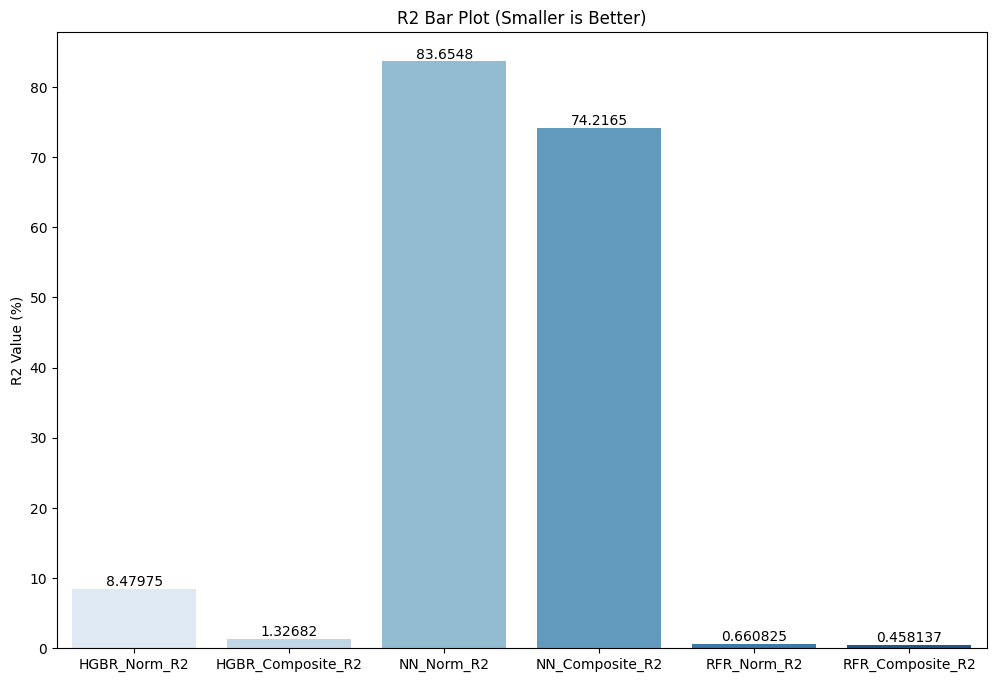

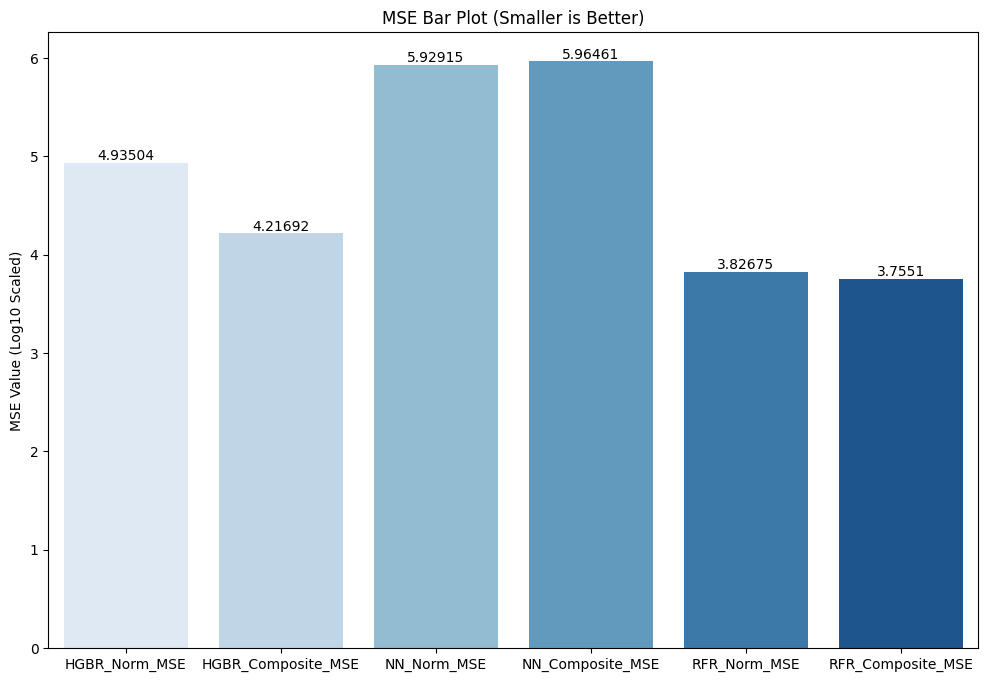

In [290]:
# -------------------------------------------- Quantitative Model Evaluation ---------------------------------------

# Join all R2 values into one list
R2_dict = {
'HGBR_Norm_R2' :HGBR_a_scores['R2'],
'HGBR_Composite_R2' :HGBR_b_scores['R2'],
'NN_Norm_R2' :NN_a_scores['R2'],
'NN_Composite_R2' :NN_b_scores['R2'],
'RFR_Norm_R2' :RFR_a_scores['R2'],
'RFR_Composite_R2' :RFR_b_scores['R2'],
}

# Join all MSE values into one list
MSE_dict = {
'HGBR_Norm_MSE' :HGBR_a_scores['MSE'],
'HGBR_Composite_MSE' :HGBR_b_scores['MSE'],
'NN_Norm_MSE' :NN_a_scores['MSE'],
'NN_Composite_MSE' :NN_b_scores['MSE'],
'RFR_Norm_MSE' :RFR_a_scores['MSE'],
'RFR_Composite_MSE' :RFR_b_scores['MSE'],
}



# Convert to Dataframe
combined_R2 = pd.DataFrame(R2_dict,index=[0])
# Switch from percentage of correct to percentage of incorect 
# and multiply by 100 to get % value
combined_R2 = (1-combined_R2)*100


# Scaled data by log10 to be more usable for graphs
combined_MSE = pd.DataFrame(MSE_dict,index=[0]).transpose()
scaled_combined_MSE = np.log10(combined_MSE)



# Plot R2 values
plt.figure(figsize=(12,8))
ax = sns.barplot(data=combined_R2,palette='Blues')

for i in ax.containers:
    ax.bar_label(i, fontsize = 10)

plt.title('R2 Bar Plot (Smaller is Better)')
plt.ylabel('R2 Value (%)')
plt.show()


# Plot MSE values
plt.figure(figsize=(12,8))
ax = sns.barplot(data=scaled_combined_MSE.transpose(),palette='Blues')

for i in ax.containers:
    ax.bar_label(i, fontsize = 10)

plt.title('MSE Bar Plot (Smaller is Better)')
plt.ylabel('MSE Value (Log10 Scaled)')
plt.show()


In [287]:
# Future Goals and current thoughts:

# - Calculate and Compare accuracy over training_time to see which gets the best results in the shortest amount of time 

# - Futher optmize the random forest model by using cross validation to try a variety of parameters and finding the best one 

# - NN Model could be optimized but from prior experience it makes only marginal differences. 
# The data and feature engineering are what are important